## Visualize data at TRAM harvest sites
### Samuli Launiainen 24.3.2022 & 11.5.2023

### Import modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import rasterio
#from rasterio.plot import show
import os
from pathlib import Path
import numpy as np
from src.raster_utils import read_pkrasteri_for_extent


## Read SpaFHy results:  
  
Average Saturation Deficit (SatDef) during harvest operation. SatDef is hydrologically adjusted TWI, goes to zero where ground water is at the surface. The domain consists of several sub-catchments modeled independently; results merged to large netCDF-file and then exported to AsciiGrid-format

In [2]:
f = r"C:\Data\TRAM\spafhy_results\site5_sat_deficit_doy_183_199.asc"

s = rasterio.open(f, 'r')
print(s.meta)
print(s.bounds)
# bbox to read peruskarttarasteri for extent of ascii-grids
bbox = s.bounds
#print(bbox)
satdef = s.read()
#satdef[satdef==-9999] = np.NaN

# read nodata mask --> set values outside sub-cathcments to zero.
smask = s.read_masks(1)
smask = smask / 255
smask[np.where(smask==0)] = np.NaN
#s.close()

{'driver': 'AAIGrid', 'dtype': 'float32', 'nodata': -9999.0, 'width': 75, 'height': 53, 'count': 1, 'crs': None, 'transform': Affine(16.0, 0.0, 323648.0,
       0.0, -16.0, 6703088.0)}
BoundingBox(left=323648.0, bottom=6702240.0, right=324848.0, top=6703088.0)


## Read vol. moisture

In [5]:
f = r"C:\Projects\TRAM\spafhy_results\combined\site5_vol_moisture_doy_183_199.asc"

v = rasterio.open(f, 'r')
print(v.meta)
print(v.bounds)
# bbox to read peruskarttarasteri for extent of ascii-grids
bbox = v.bounds
#print(bbox)
wliq = v.read()
#wliq[wliq==-9999] = np.NaN
# read nodata mask
wmask = v.read_masks(1)
wmask = wmask / 255
#print(np.unique(wmask))
wmask[np.where(wmask==0)] = np.NaN
#s.close()

{'driver': 'AAIGrid', 'dtype': 'float32', 'nodata': -9999.0, 'width': 75, 'height': 53, 'count': 1, 'crs': None, 'transform': Affine(16.0, 0.0, 323648.0,
       0.0, -16.0, 6703088.0)}
BoundingBox(left=323648.0, bottom=6702240.0, right=324848.0, top=6703088.0)


## Read Peruskartta geotiff and plot raster overlays.  
See RasterProcessing -notebook how singleband pk-tiff was created. Note: needs tweak'ing to plot colorbar.  

Note Vol. moisture outsize forest incorrect; need to fix LAI and vegetation parameters.

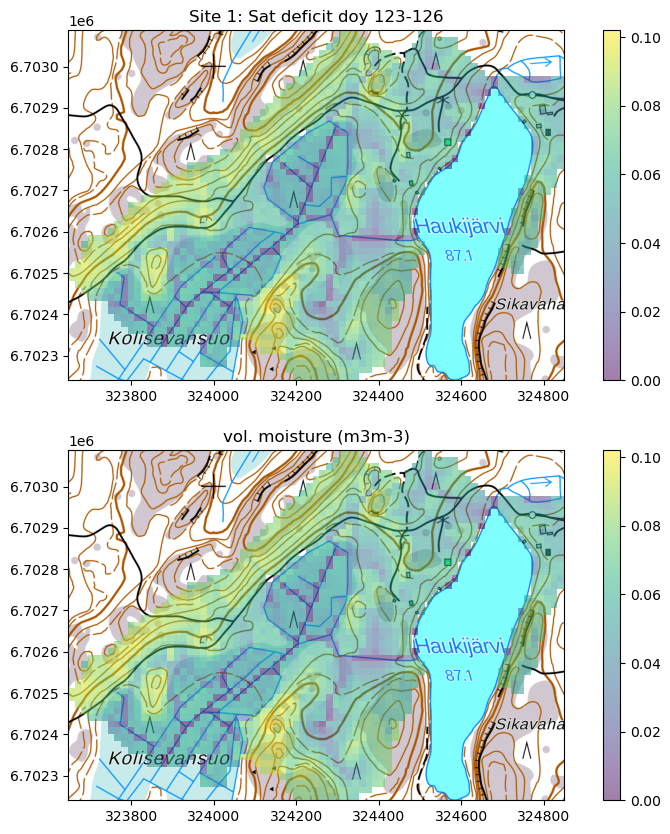

In [4]:
# read peruskarttarasteri
f = r"c:\Data\Tram\pkrasteri\TRAM_peruskartta.tif"

pk, meta = read_pkrasteri_for_extent(f, bbox, showfig=False)

# show raster overlays
plt.close('all')

fig1, ax1 = plt.subplots(2,1, figsize=(10,10))
rasterio.plot.show(pk, transform=meta['transform'], ax=ax1[0])

rr = rasterio.plot.show(satdef * smask, transform=s.transform, ax=ax1[0], alpha=0.5)
# this creates colorbar
im = rr.get_images()[1]
ax1[0].set_title('Site 1: Sat deficit doy 123-126')
fig1.colorbar(im, ax=ax1[0], shrink=1)

rasterio.plot.show(pk, transform=meta['transform'], ax=ax1[1]);
#show(twi * mask, transform=r.transform, ax=ax1, alpha=0.5, vmin=5., vmax=10.0)
rr = rasterio.plot.show(wliq * wmask, transform=v.transform, ax=ax1[1], alpha=0.5)
im = rr.get_images()[1]
ax1[1].set_title('vol. moisture (m3m-3)')
fig1.colorbar(im, ax=ax1[1], shrink=1)
plt.show()

fig1.savefig('Site1_moisture.png', dpi=300)

## Estimate amount of logs and fibre from mNFI data.

### Csaba - here is one possibility; here site 5 used as an example.

- Read mNFI variables (m3 ha-1)
- convert volumes to mass per grid-cell: asume density of fresh wood is 850 kg m-3
- Ponsse forwarder maximum capacity in 14 tons
- In clear-cutting all logs + fibre harvested
- In thinnings, the thinning intensity should be based on variable 'ppa' (basal area, m2 ha-1). Let's assing thinning target to be 16m2 ha-1; the removed basal area fraction is then:
fBA = max(0, BA - 16.0) / BA, where BA == ppa in the data.
- Let's further assume that removed volumes and mass are proportional to fBA. For the 1st guess: assume all thinned wood is 'fibre', 2nd guess could be 1/3 is logs and 2/3 fibre.

## Close rasterfiles

In [5]:

v.close()
s.close()

In [23]:
f = np.where(data>1000)
f

(array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 array([  0,   0,   0, ..., 110, 111, 111], dtype=int64),
 array([122, 123, 124, ..., 299, 298, 299], dtype=int64))